In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import logging
import os
from scipy import interpolate, optimize
from scipy import integrate
import warnings
warnings.filterwarnings("error")
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:
def read_tri_lodeAlt_eps_from_fem(fileName):
    """
    read all sheets in xls file
    input:
        fileName
    output:
        listEta, listThetaBar, listEpsilon in sheets
    """
    xlsx = pd.ExcelFile(fileName)
    etaThetaEpsilon = []
    for sheet in xlsx.sheet_names:
        #print(sheet)
        df = pd.read_excel(xlsx, sheet)
        eta = df.loc[:, 'TRI'].values.reshape(-1, 1)
        '''
        lsdyna has different defination of lode parameter 27J3/2*sigma^3 than mmc,
        transfer lsdyna result to mmc model
        '''
        lodeAlt = df.loc[:, 'LODEALT'].values.reshape(-1, 1)
        thetaBar = 1 - 2 / np.pi * np.arccos(lodeAlt)
        
        eplison = df.loc[:, 'EPS'].values.reshape(-1, 1)
        ind = np.where(eplison>0)
        #print(sheet)
        #print(ind)
        ete = np.hstack([eta, thetaBar, eplison])
        
        etaThetaEpsilon.append(ete[ind[0],:])
    
    #logging.debug(etaThetaEpsilon)
    etaThetaEpsilon = np.array(etaThetaEpsilon)
    return etaThetaEpsilon

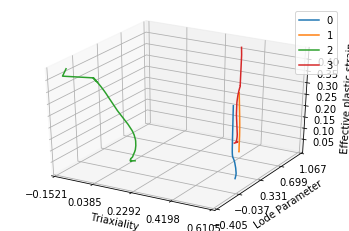

In [4]:
tests = read_tri_lodeAlt_eps_from_fem('FEM.xlsx')

fig = plt.figure()

ax = fig.gca(projection='3d')
plots = []
labels = []
ii = 0
for test in tests:
    xx, yy, zz = test[:, 0], test[:, 1], test[:, 2]
    pl = ax.plot(xx, yy, zz, label=str(ii))#, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    plots.append(pl)
    labels.append(str(ii))
    ii = ii + 1
    
ax.legend()#
ax.xaxis.set_major_locator(LinearLocator(5))
ax.yaxis.set_major_locator(LinearLocator(5))
ax.set_xlabel('Triaxiality')
ax.set_ylabel('Lode Parameter')
ax.set_zlabel('Effective plastic strain')

plt.show()

In [5]:

def simplifiedMMC(eta, thetaBar, param):
    """
    Ref. Application of extended Mohr Coulomb criterion to ductile fracture Eq. 25
    output:
        epsilonPlasticFailure: failure strain
    """
    A, n, c1, c2 = param
    try:
        unit = thetaBar * np.pi / 6
    #print(param)
        comp1 = np.sqrt((1+np.power(c1, 2)) / 3) * np.cos(unit)
    #print(comp1.shape)
        comp2 = c1 * (eta + 1 / 3 * np.sin(thetaBar * unit))
    #print(A / c2 * (comp1 + comp2), -1/n)
        comp = comp1 + comp2
    #comp = comp[np.where(comp>0)]
        epsilonPlasticFailure = np.power(A / c2 * comp, -1/n)
    #print(epsilonPlasticFailure.shape)
    #print(np.any(np.isnan(epsilonPlasticFailure)))
    except(RuntimeWarning):
        print('run time warning',A, n, c1, c2)
        epsilonPlasticFailure = np.zeros(comp.shape)
    
    return epsilonPlasticFailure

In [6]:
def accumulatedDamage(model, eta, thetaBar, epsilon, param):
    """
    Accumulating Damage Model
    input:
        model: Damage mode
        eta: eta list
        thetaBar: theraBar list
        epsilon: epsilon List
        param: A, n, c1, c2
    output:
        damage Indicator
    """
    #'epsilonMMC = np.zeros(eta.shape)'
    #'for ii, (eta, thetaBar) in  enumerate(zip(eta, thetaBar)):'
    epsilonPlasticFailure = model(eta, thetaBar, param)
    #'epsilonMMC[ii] = epsilonPlaticFailure'
   
    damageIndicator = integrate.trapz(1/ epsilonPlasticFailure, epsilon)
                      #np.sum(epsilon / epsilonPlasticFailure)
                      #integrate.tr (1 / epsilonPlaticFailure, epsilon)

    #print(epsilonPlasticFailure)
    return damageIndicator


In [7]:
def MMCSurface(*param):
    eta = np.arange(-0.99, .99, 0.1)
    theta = np.arange(-0.99, .99, 0.1)
    
    etaX, thetaY = np.meshgrid(eta, theta, sparse=False)
    #z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
    #h = plt.contourf(x,y,z)
    epsilon = simplifiedMMC(etaX, thetaY, param)
    '''
        lsdyna has different defination of lode parameter than mmc,
        transfer mmc model to lsdyna format
    '''
    return etaX, thetaY, epsilon

In [8]:
def testResultsAcc(param, tests):
    """
    tests result to damgaIndicator
    """
    indicators = np.zeros([tests.shape[0]])
    for ii, test in enumerate(tests):
        eta = test[:, 0]
        theta = test[:, 1]
        epsilon = test[:, 2]
        damageIndicator = accumulatedDamage(simplifiedMMC, eta, theta, epsilon, param)
        #print(damageIndicator)
        indicators[ii] = damageIndicator
    return indicators

def errAcc(param, x, y):
    global A, n
    c1, c2 = param
    #print(Paramters.A, Paramters.n)
    return testResultsAcc((A,n, c1, c2), x) - y

def fitDamageAcc(tests):
    targets = np.ones([tests.shape[0]])
    #result = testResults(tests,(996.68, 0.026, 0.1, 500))
    res = optimize.least_squares(errAcc, (0.1, 500), bounds=([0,0],[1000,10000]), args=(tests, targets))
    return res

In [9]:
A = 2809.65
n = 0.10277
resAcc = fitDamageAcc(tests)

In [10]:
resAcc.x

array([5.20658915e-02, 1.48919856e+03])

In [11]:
def showFigure(faiureSurface, tests):
    XX, YY, zz = faiureSurface
    fig = plt.figure()
    #plt.xlabel('Triaxiality')
    #plt.ylabel('Lode Parameter')
    #plt.zlabel('Failure plastic strain')
    ax = fig.gca(projection='3d')
    #cs = ax.contourf(X, Y, z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
    #cbar = fig.colorbar(cs)
    
    ax.scatter3D(XX, YY, zz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    for test in tests:
        '''
        lsdyna has different defination of lode parameter than mmc,
        transfer mmc model to lsdyna format
        '''
        xx, yy, zz = test[:, 0], test[:, 1], test[:, 2]
        ax.plot(xx, yy, zz)#, cmap=cm.coolwarm,linewidth=0, antialiased=False)
 
    ax.xaxis.set_major_locator(LinearLocator(5))
    ax.yaxis.set_major_locator(LinearLocator(5))
    ax.set_xlabel('Triaxiality')
    ax.set_ylabel('Lode Parameter')
    ax.set_zlabel('Failure plastic strain')
    ax.set_zbound([0,1.5])
    #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f')
    plt.show()

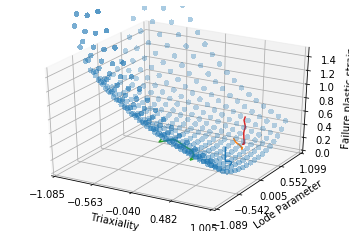

In [12]:
failureSurface = MMCSurface(A, n, resAcc.x[0], resAcc.x[1])
showFigure(failureSurface, tests)

In [13]:
def writeTable(failueSurface):
    etaX, thetaY, strain = failueSurface
    #print (etaX, thetaY)
    eta = etaX[0, :]
    theta = np.cos(np.pi / 2 * (1 -  thetaY[:, 0]))
    
    print(eta.shape, strain.shape)
    with open ('mmc.tab','w+') as f:
        
        f.write('*DEFINE_TABLE\n')
        f.write('$#Lode Parameter vs. load curves'+'\n')
        f.write('$'+'{:>9}'.format('TBID')+'\n')
        f.write(' '+'{:>9d}'.format(5550)+'\n')
        f.write('$'+'{:>9}'.format(' ')+
            '{:>10}'.format('VALUE')+
            '{:>10}'.format('LCID')+'\n')
        
        for ii, ll in enumerate(theta):
            #print(ii)
            f.write('{:>10}'.format(' ')+
                '{:>10.3f}'.format(ll)+
                '{:10d}'.format(ii+5551)+'\n')
        f.write('$'+'\n')
        
        for ii, _ in enumerate(theta):
            f.write('*DEFINE_CURVE'+'\n')
            f.write('$#Triaxiality vs. Failure Plastic Strain'+'\n')
            f.write('$'+'{:>9}'.format('LCID')+
                '{:>10}'.format('SIDR') + 
                '{:>10}'.format('SCLA') + 
                '{:>10}'.format('SCLO') + 
                '{:>10}'.format('OFFA') +
                '{:>10}'.format('OFFO') +
                '{:>10}'.format('DATTYP') +
                '{:>10}'.format(' ')+'\n')

            f.write('{:>10d}'.format(ii+5551)+
                '{:>10d}'.format(0) + 
                '{:>10.2f}'.format(1.0) + 
                '{:>10.2f}'.format(1.0) + 
                '{:>10.2f}'.format(0.0) +
                '{:>10.2f}'.format(0.0) +
                '{:>10d}'.format(0) +
                '{:>10d}'.format(0) + '\n')

            f.write('$'+'{:>9}'.format(' ')+
                '{:>10}'.format('A1')+
                '{:>10}'.format(' ')+
                '{:>10}'.format('O1')+'\n')
            for jj, tt in enumerate(eta):
                f.write('{:>10}'.format(' ')+
                    '{:>10.3f}'.format(tt) + 
                    '{:>10}'.format(' ') +
                    '{:>10.2e}'.format(strain[ii,jj])+'\n')


In [20]:
writeTable(failureSurface)
etaX, thetaY, strain = failueSurface

import scipy.io as sio
sio.savemat('sfc.mat', {'sfc': np.array(failureSurface)})

(20,) (20, 20)
(3, 20, 20)


RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject